# Sentiment Analysis using BERT

BERT (Bidirectionnal Encoder Representations for Transformers) is a “new method of pre-training language representations” developed by Google and released in late 2018.

### Import Libraries and Set the intial variables

In [ ]:
pip install --upgrade pip

In [1]:
!pip install transformers

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [7]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the data

In [8]:
df = pd.read_csv('../input/covid-19/Corona_NLP_train.csv', encoding = 'latin-1')
df.shape

(41157, 6)

In [9]:
# Let's have a look at the data 
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


We can see that the most relevant column for us is content and replyContent and the score as well.

In [10]:
# Let's check for missing values 
df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

There are missing values in some of the columns but Content and score don't have a missing value. We can also look at the class balance. 

We will be alloting three classes:- 
1. Positive (Score: 4-5)
2. Neutral (Score: 3)
3. Negative (Score: 1-2)

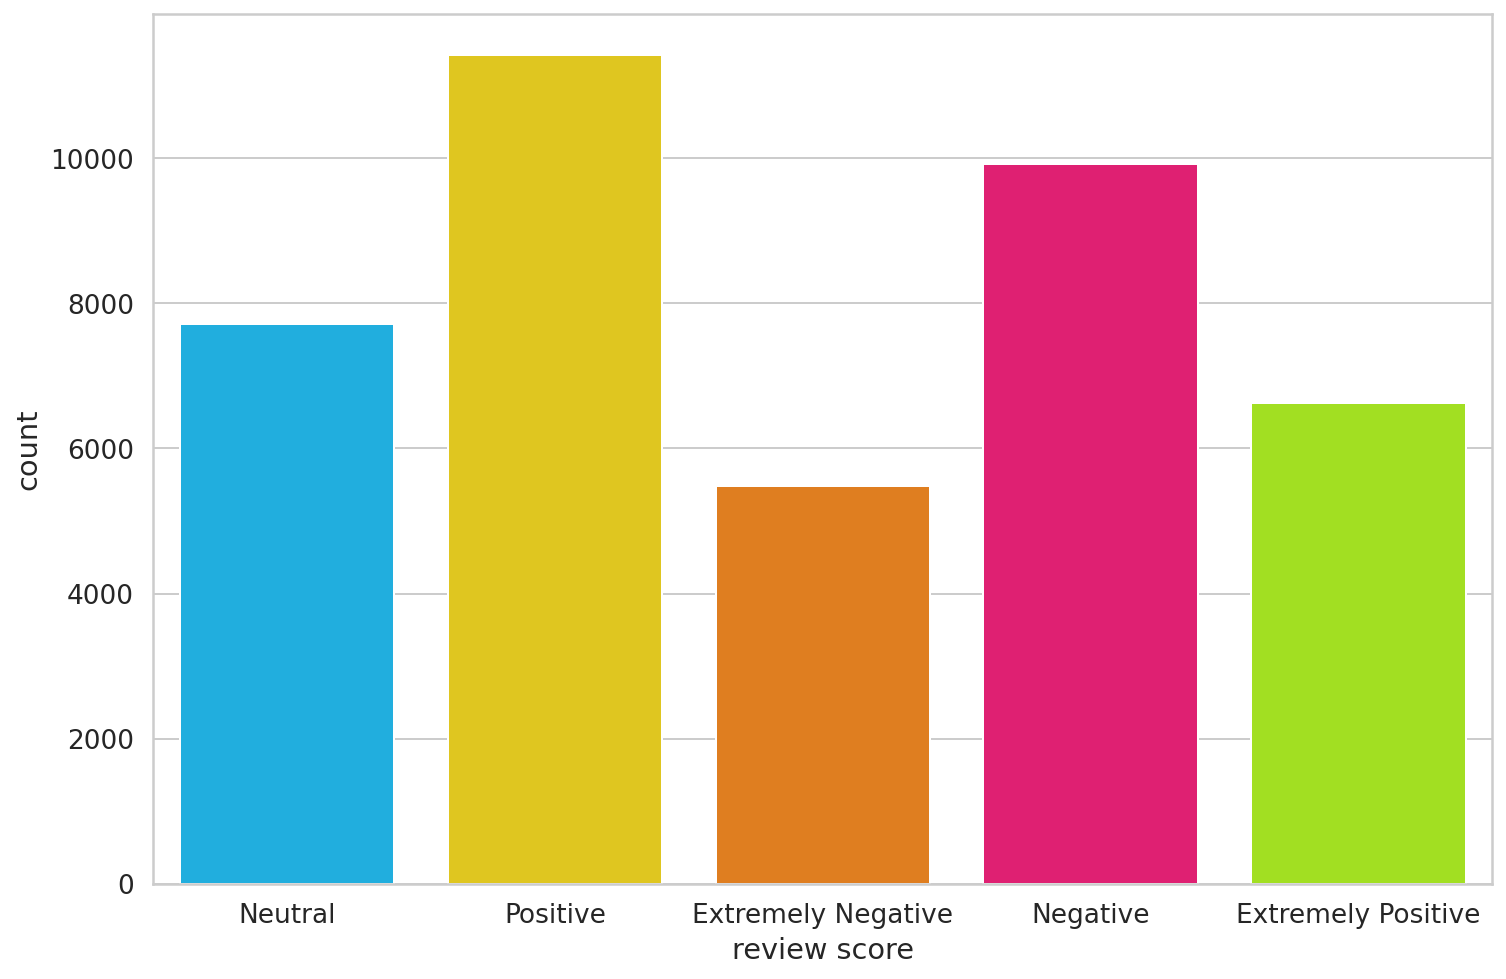

In [11]:
# Let's have a look at the class balance.
sns.countplot(df.Sentiment)
plt.xlabel('review score');

We can see that we have more positive classes than negative and low number of neutral class. I have kept neutral less to focus more on positive and negative classes. Let's allot classes based on scores now. 

* 0 - negative
* 1 - neutral 
* 2 - positive

In [12]:
# Function to convert score to sentiment
def to_sentiment(rating):
    
    if(rating=='Neutral'):
        return 2
    elif rating=='Positive':
        return 3
    elif rating=='Extremely Positive':
        return 4
    elif rating=='Negative':
        return 1
    elif rating=='Extremely Negative':
        return 0

# Apply to the dataset 
df['sentiment'] = df.Sentiment.apply(to_sentiment)

In [ ]:
# Plot the distribution
class_names = ['Extremely negative', 'Negative','Neutral', 'Positive','Extremely Positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation. 

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word. 

In [ ]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
# tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [ ]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.OriginalTweet:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

In [ ]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160. 

In [ ]:
MAX_LEN = 160

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily. 

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

Create a 80% train data and 10% test and 10% validation data

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

Create a dataloader to release data in batches.

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.OriginalTweet.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [ ]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [ ]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)
    
#     def __init__(self, bert):
#         super(BERT_Arch, self).__init__()
#         self.bert = BertModel.from_pretrained('bert-base-uncased')
#         self.conv = nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 768), padding=True)
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool2d(kernel_size=3, stride=1)
#         self.dropout = nn.Dropout(0.1)
#         self.fc = nn.Linear(442, 3) # before : 442 with max_length 36 # 806 with max_length 64
#         self.flat = nn.Flatten()
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, sent_id, mask):
#         _, _, all_layers = self.bert(sent_id, attention_mask=mask, output_hidden_states=True)
#         # all_layers  = [13, 32, 64, 768]
#         x = torch.transpose(torch.cat(tuple([t.unsqueeze(0) for t in all_layers]), 0), 0, 1)
#         del all_layers
#         gc.collect()
#         torch.cuda.empty_cache()
#         x = self.pool(self.dropout(self.relu(self.conv(self.dropout(x)))))
#         x = self.fc(self.dropout(self.flat(self.dropout(x))))
#         return self.softmax(x)

In [ ]:
df.head()

In [3]:
"""
 @Time : 15/12/2020 19:01
 @Author : Alaa Grable
 """

!pip install transformers==3.0.0
!pip install emoji
import gc
#import os
import emoji as emoji
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoModel
from transformers import BertModel, BertTokenizer

In [4]:


class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.conv = nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 768), padding=True)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(442, 5) # before : 442 with max_length 36 # 806 with max_length 64
        self.flat = nn.Flatten()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, _, all_layers = self.bert(sent_id, attention_mask=mask, output_hidden_states=True)
        # all_layers  = [13, 32, 64, 768]
        x = torch.transpose(torch.cat(tuple([t.unsqueeze(0) for t in all_layers]), 0), 0, 1)
        del all_layers
#         gc.collect()
#         torch.cuda.empty_cache()
        x = self.pool(self.dropout(self.relu(self.conv(self.dropout(x)))))
        x = self.fc(self.dropout(self.flat(self.dropout(x))))
        return self.softmax(x)


def read_dataset():
    data = pd.read_csv("/kaggle/input/covid-19/Corona_NLP_train.csv", encoding = 'latin-1')
    data = data.drop(['ScreenName', 'Location', 'TweetAt'], axis=1)
    #data = data.loc[0:9599,:]
    print(len(data))
    # Apply to the dataset 
    data['sentiment'] = data.Sentiment.apply(to_sentiment)
    return data['OriginalTweet'].tolist(), data['sentiment']


def pre_process_dataset(values):
    new_values = list()
    # Emoticons
    emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']

    for value in values:
        # Remove dots
        text = value.replace(".", "").lower()
        text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
        users = re.findall("[@]\w+", text)
        for user in users:
            text = text.replace(user, "<user>")
        urls = re.findall(r'(https?://[^\s]+)', text)
        if len(urls) != 0:
            for url in urls:
                text = text.replace(url, "<url >")
        for emo in text:
            if emo in emoji.UNICODE_EMOJI:
                text = text.replace(emo, "<emoticon >")
        for emo in emoticons:
            text = text.replace(emo, "<emoticon >")
        numbers = re.findall('[0-9]+', text)
        for number in numbers:
            text = text.replace(number, "<number >")
        text = text.replace('#', "<hashtag >")
        text = re.sub(r"([?.!,¿])", r" ", text)
        text = "".join(l for l in text if l not in string.punctuation)
        text = re.sub(r'[" "]+', " ", text)
        new_values.append(text)
    return new_values


def data_process(data, labels):
    input_ids = []
    attention_masks = []
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    for sentence in data:
        bert_inp = bert_tokenizer.__call__(sentence, max_length=36,
                                           padding='max_length', pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)

        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])
    #del bert_tokenizer
    #gc.collect()
    #torch.cuda.empty_cache()
    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    return input_ids, attention_masks, labels


def load_and_process():
    data, labels = read_dataset()
    num_of_labels = len(labels.unique())
    input_ids, attention_masks, labels = data_process(pre_process_dataset(data), labels)

    return input_ids, attention_masks, labels




In [5]:
device='cpu'

In [13]:
# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    total = len(train_dataloader)
    for i, batch in enumerate(train_dataloader):

        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>'  *(filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        del batch
#         gc.collect()
#         torch.cuda.empty_cache()
        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        #sent_id = torch.tensor(sent_id).to(device).long()
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss += float(loss.item())

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        #preds = preds.detach().cpu().numpy()

        # append the model predictions
        #total_preds.append(preds)
        total_preds.append(preds.detach().cpu().numpy())

#     gc.collect()
#     torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / (len(train_dataloader)*batch_size)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss and predictions
    return avg_loss, total_preds


# function for evaluating the model
def evaluate():
    print("\n\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    total = len(val_dataloader)
    for i, batch in enumerate(val_dataloader):
        
        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch
        del batch
#         gc.collect()
#         torch.cuda.empty_cache()
        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss += float(loss.item())
            #preds = preds.detach().cpu().numpy()

            #total_preds.append(preds)
            total_preds.append(preds.detach().cpu().numpy())

#     gc.collect()
#     torch.cuda.empty_cache()

    # compute the validation loss of the epoch
    avg_loss = total_loss / (len(val_dataloader)*batch_size)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

# Specify the GPU
# Setting up the device for GPU usage
device = 'cpu'
print(device)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Load Data-set ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
input_ids, attention_masks, labels = load_and_process()
df = pd.DataFrame(list(zip(input_ids, attention_masks)), columns=['input_ids', 'attention_masks'])
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ class distribution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
# ~~~~~~~~~~ Split train data-set into train, validation and test sets  ~~~~~~~~~~#
train_text, temp_text, train_labels, temp_labels = train_test_split(df, labels,
                             random_state=2018, test_size=0.2, stratify=labels)

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                         random_state=2018, test_size=0.5, stratify=temp_labels)

del temp_text
# gc.collect()
# torch.cuda.empty_cache()

train_count = len(train_labels)
test_count = len(test_labels)
val_count = len(val_labels)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~ Import BERT Model and BERT Tokenizer ~~~~~~~~~~~~~~~~~~~~~#
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# bert = AutoModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Tokenization ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for train set
train_seq = torch.tensor(train_text['input_ids'].tolist())
train_mask = torch.tensor(train_text['attention_masks'].tolist())
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(val_text['input_ids'].tolist())
val_mask = torch.tensor(val_text['attention_masks'].tolist())
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(test_text['input_ids'].tolist())
test_mask = torch.tensor(test_text['attention_masks'].tolist())
test_y = torch.tensor(test_labels.tolist())
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Create DataLoaders ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Freeze BERT Parameters ~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
# push the model to GPU
model = model.to(device)

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

#from sklearn.utils.class_weight import compute_class_weight

# compute the class weights
#class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

#print(class_wts)

# convert class weights to tensor
#weights = torch.tensor(class_wts, dtype=torch.float)
#weights = weights.to(device)

# loss function
#cross_entropy = nn.NLLLoss(weight=weights)
cross_entropy = nn.NLLLoss()

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
#train_losses = []
#valid_losses = []

#if os.path.isfile("/content/drive/MyDrive/saved_weights.pth") == False:
#if os.path.isfile("saved_weights.pth") == False:
    # number of training epochs
epochs = 3
current = 1
# for each epoch
while current <= epochs:

    print(f'\nEpoch {current} / {epochs}:')

    # train model
    train_loss, _ = train()

    # evaluate model
    valid_loss, _ = evaluate()

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'saved_weights.pth')

    # append training and validation loss
    #train_losses.append(train_loss)
    #valid_losses.append(valid_loss)

    print(f'\n\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    current = current + 1
#else:
    #print("Got weights!")
    # load weights of best model
    #model.load_state_dict(torch.load("saved_weights.pth"))
    #model.load_state_dict(torch.load("/content/drive/MyDrive/saved_weights.pth"), strict=False)

# get predictions for test data
# gc.collect()
# torch.cuda.empty_cache()

with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    #preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()


print("Performance:")
# model's performance
preds = np.argmax(preds, axis=1)
print('Classification Report')
print(classification_report(test_y, preds))

print("Accuracy: " + str(accuracy_score(test_y, preds)))

cpu
41157




Epoch 1 / 3:
Batch 1029/1029 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.03, accuracy=0

Evaluating...
Batch 129/129 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.03, accuracy=0

Training Loss: 0.034
Validation Loss: 0.026

Epoch 2 / 3:
Batch 1029/1029 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Evaluating...
Batch 129/129 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Training Loss: 0.023
Validation Loss: 0.023

Epoch 3 / 3:
Batch 1029/1029 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Evaluating...
Batch 129/129 |████████████████

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [ ]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

#### Model Characterstics

In [ ]:
# Number of hidden units
print(bert_model.config.hidden_size)

### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [ ]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

Write the training Loop and store the best training state.

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

In [ ]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
loaded_model = SentimentClassifier(len(class_names))
loaded_model = loaded_model.to(device)
loaded_model.load_state_dict(torch.load('best_model_state.bin'))

In [ ]:
test_acc, _ = eval_model(
  loaded_model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

### Model Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

## Predicting on raw text

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')